In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
class MAB:
    
    def __init__ (self, reward_dist, bandits_mean, stdv = 0.01):
        
        self.reward_dist  = reward_dist
        self.bandits_mean = bandits_mean
        self.stdv         = stdv
        
    def pull_arm (self, k):

        '''
        pull the arm k and obtain the reward based on gaussian distribution
        return the reward and the regret associated with that arm
        '''
        if self.reward_dist == 'Bernoulli':
          return np.random.binomial(1,self.bandits_mean[k]), (np.max(self.bandits_mean) - self.bandits_mean[k])
        elif self.reward_dist == 'Gaussian':
          return np.random.normal(loc = self.bandits_mean[k], scale = self.stdv), (np.max(self.bandits_mean) - self.bandits_mean[k])


In [3]:
class Epsilon_Greedy:   
    def __init__(self, epsilon = 0.1):
        self.epsilon = epsilon
    
    def action(self, reward_estimates, num_arms_played, n_bandits):
        return np.argmax(reward_estimates) if (np.random.uniform(0,1)>self.epsilon) else np.random.randint(0,n_bandits)


In [4]:
class Variable_Epsilon_Greedy:
    
    def __init__(self, epsilon = 0.1):
        self.epsilon = epsilon 
        self.c = 0.2
        self.d = 0.05 
    
    def action(self, reward_estimates, num_arms_played, n_bandits):
        total_count = np.sum(num_arms_played)
        epsilon = min(((n_bandits*self.c)/((self.d**2)*(max(total_count,1)))), 1)  
        
        return np.argmax(reward_estimates) if (np.random.uniform(0,1)>epsilon) else np.random.randint(0,n_bandits)


In [5]:
class Softmax:
    def __init__(self,temp = 1):
        self.temp = temp
        
    def action(self, reward_estimates, num_arms_played, n_bandits):
        softmax_prob = np.exp(reward_estimates/ self.temp)
        softmax_prob = softmax_prob/(np.sum(softmax_prob))
        
        return np.random.choice(n_bandits, p = softmax_prob[0,:])


In [6]:
class UCB:
    
    def __init__(self):
        pass
    
    def action(self, reward_estimates, num_arms_played, n_bandits):
        
        if (np.sum(num_arms_played) < n_bandits):
          for i in range(n_bandits): 
            if (num_arms_played[0,i] == 0):
              return i 
           

        confidence_term = np.sqrt((2*np.log(np.sum(num_arms_played)))/(num_arms_played))
    
        return np.argmax(reward_estimates + confidence_term)

In [7]:
class UCB1_Normal:
    
    def __init__(self, n_bandits):
        self.q = np.zeros((1,n_bandits))
    
    def action(self, reward_estimates, num_arms_played, n_bandits, **kargs):
        
        for i in range(n_bandits): 
          if (num_arms_played[0,i] <= np.ceil(8*np.log(np.sum(num_arms_played)+1))):
            return i 
        confidence_term = np.sqrt((16*np.abs(self.q- num_arms_played*(reward_estimates**2))*np.log(np.sum(num_arms_played)-1))/(num_arms_played*(num_arms_played-1)))
    
        return np.argmax(reward_estimates + confidence_term)
    
    def update_q(self, reward, a_t, num_plays):
        self.q[0,a_t] += (reward**2 - self.q[0,a_t])/(num_plays)

In [8]:
class TS :

    def __init__(self, reward_dist):
        self.reward_dist = reward_dist
       
        
    def action(self,  reward_estimates, num_arms_played, n_bandits):
        
        if self.reward_dist == 'Bernoulli':

          success_count = num_arms_played[0,:] * reward_estimates[0,:]
          failure_count = num_arms_played[0,:] - success_count
          
          samples_list = [np.random.beta(success_count[bandit_id]+1, failure_count[bandit_id]+1) for bandit_id in range(n_bandits)]

        elif self.reward_dist == 'Gaussian':  
           

          samples_list = [np.random.normal(loc = reward_estimates[0,bandit_id], scale = 1/(num_arms_played[0,bandit_id]+1)) for bandit_id in range(n_bandits)]
        
        a_t = np.argmax(samples_list) 
        
        
        return a_t

In [9]:
class TS_Gaussian :

    def __init__(self, n_bandits):
     
        self.prior_mean = np.zeros((1,n_bandits))
        self.nu = np.ones((1,n_bandits))
        
        
        self.init_alpha = 1*np.ones((1,n_bandits))
        self.init_beta = 1*np.ones((1,n_bandits))
        
        self.alpha = self.init_alpha
        self.beta = self.init_beta
        
        self.s = np.zeros((1,n_bandits))
    
    def action(self,  reward_estimates, num_arms_played, n_bandits):
        
        """
        num_arms_played : Contains the number of times each arm is played
        reward_estimates = contains the reward estimate for each arm
        n_banits : Contains the indexes of the arms
        """
        
        var_est = [stats.invgamma.rvs(a = self.alpha[0,bandit_id], scale = self.beta[0, bandit_id]) for bandit_id in range(n_bandits)]
        
        mu_var = var_est/(num_arms_played + self.nu)
        rho = (self.nu*self.prior_mean + num_arms_played*reward_estimates)/(self.nu + num_arms_played)
        
        samples_list = [np.random.normal(loc = rho[0,bandit_id], scale = mu_var[0,bandit_id]) for bandit_id in range(n_bandits)]

        a_t = np.argmax(samples_list) 
        return a_t
    
    def update(self, reward_estimate, reward, a_t, num_plays):
        
        self.s[0,a_t]  += reward**2 + (num_plays) * ((reward_estimate +  (( reward_estimate - reward)/(num_plays)))**2) - (num_plays+1) * (reward_estimate**2)
        self.beta[0,a_t] = self.init_beta[0,a_t] + 0.5*self.s[0,a_t] + (num_plays*self.nu[0,a_t]*((reward_estimate - self.prior_mean[0,a_t])**2))/(2*(num_plays + self.nu[0,a_t]))
        self.alpha[0, a_t] = 0.5*num_plays + self.init_alpha[0,a_t]

In [10]:
class Reinforce:

  def __init__(self, n_bandits, learning_rate = 0.1):
    self.w = np.random.random(size = (1,n_bandits))
    self.lr = learning_rate

    self.probs = np.ones(shape = (1,n_bandits))/(n_bandits) # equal probability for all the arms in the beginning

  def action(self, reward_estimtes, num_arms_played, n_bandits):

     """
        num_arms_played : Contains the number of times each arm is played
        reward_estimates = contains the reward estimate for each arm
        n_bandits : Contains the indexes of the arms
    """
     return np.random.choice(n_bandits, p = self.probs[0,:])

  def update_weights(self, a_t, reward_t, avg_reward):

    
    self.w += - self.lr*(reward_t)*self.probs
    self.w[0,a_t] +=  self.lr*(reward_t) 
    
   

    self.probs = (np.exp(self.w)/(np.sum(np.exp(self.w))))

In [11]:
class Reinforce_Baseline:

  def __init__(self, n_bandits, learning_rate = 0.1):
    """
    Input:
      n_bandits : No. of bandits 

    Task Performed:
      Initialize the parameters randomly
      Initialize the learning rate
      Initialize the probability of picking an arm to be uniformly random

    """
    self.w = np.random.random(size = (1,n_bandits))
    self.lr = learning_rate

    self.probs = np.ones(shape = (1,n_bandits))/(n_bandits) # equal probability for all the arms in the beginning

  def action(self, reward_estimtes, num_arms_played, n_bandits):

     """
        num_arms_played : Contains the number of times each arm is played
        reward_estimates = contains the reward estimate for each arm
        n_bandits : Contains the indexes of the arms

        Note : Here we don't need the information of reward estimates and no. of times each arm is played
    """
     return np.random.choice(n_bandits, p = self.probs[0,:])

  def update_weights(self, a_t, reward_t, avg_reward):
    """
    Update the weight parameters using the update rule
    Update the probabilities of picking the arm after updating the weights
    """
    
    self.w += - self.lr*(reward_t - avg_reward)*self.probs
    self.w[0,a_t] +=  self.lr*(reward_t - avg_reward) 
    
    self.probs = (np.exp(self.w)/(np.sum(np.exp(self.w))))


In [14]:
K_list            = [2,5,10]


T        = 20000  
num_runs = 20    
num_algorithms = 7


epsilon = 0.1

softmax_temp = 0.05

algo_labels = [f"Epsilon Greedy with epsilon = {epsilon}", "Variable-Epsilon Greedy", f"Softmax with temp = {softmax_temp}", "Upper Confidence Bound", "Thompson Sampling", "Reinforce Algorithm", "Reinforce With Baseline"]




******************************** NUMBER OF ARMS : 2 ********************************

Each algorithm was played 20 times and the episode length was 20000

The total regret accumulated over time for Epsilon Greedy with epsilon = 0.1 is 294.029

The total regret accumulated over time for Variable-Epsilon Greedy is 123.934

The total regret accumulated over time for Softmax with temp = 0.05 is 913.585

The total regret accumulated over time for Upper Confidence Bound is 73.522

The total regret accumulated over time for Thompson Sampling is 11.896

The total regret accumulated over time for Reinforce Algorithm is 45.307

The total regret accumulated over time for Reinforce With Baseline is 38.470



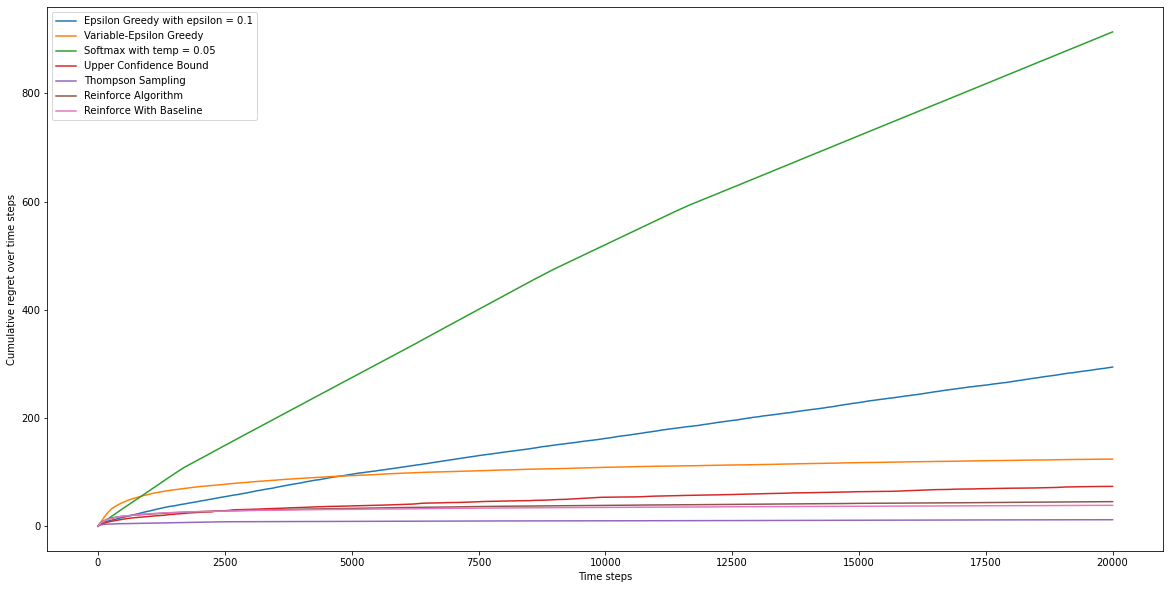

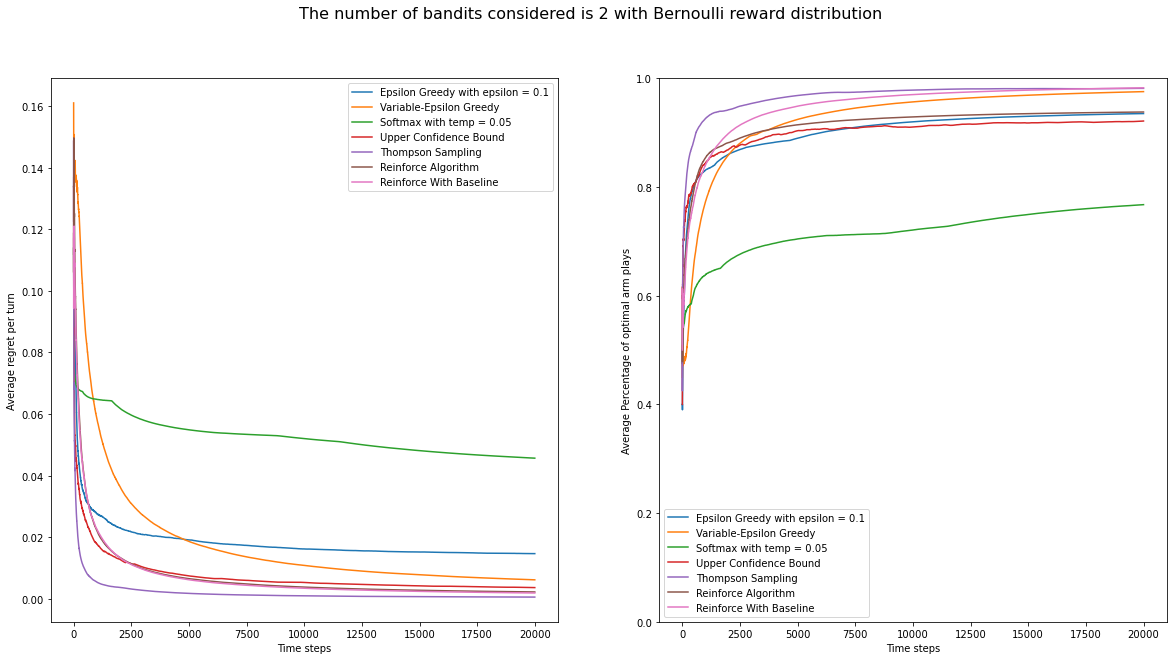



******************************** NUMBER OF ARMS : 5 ********************************

Each algorithm was played 20 times and the episode length was 20000

The total regret accumulated over time for Epsilon Greedy with epsilon = 0.1 is 648.007

The total regret accumulated over time for Variable-Epsilon Greedy is 585.344

The total regret accumulated over time for Softmax with temp = 0.05 is 1911.924

The total regret accumulated over time for Upper Confidence Bound is 225.236

The total regret accumulated over time for Thompson Sampling is 41.482

The total regret accumulated over time for Reinforce Algorithm is 228.776

The total regret accumulated over time for Reinforce With Baseline is 117.283



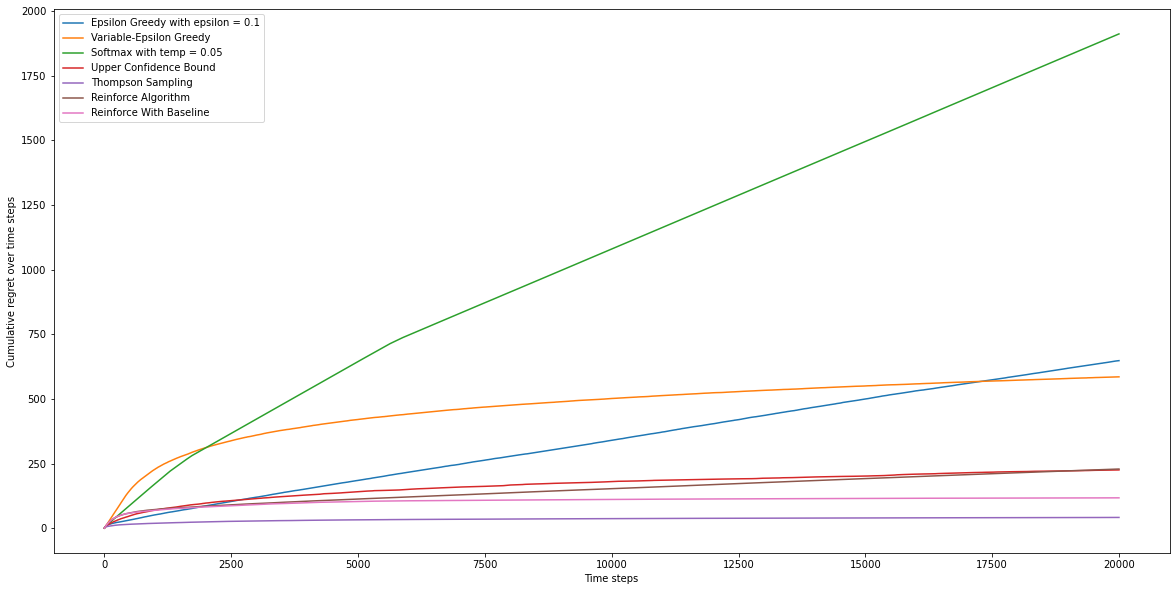

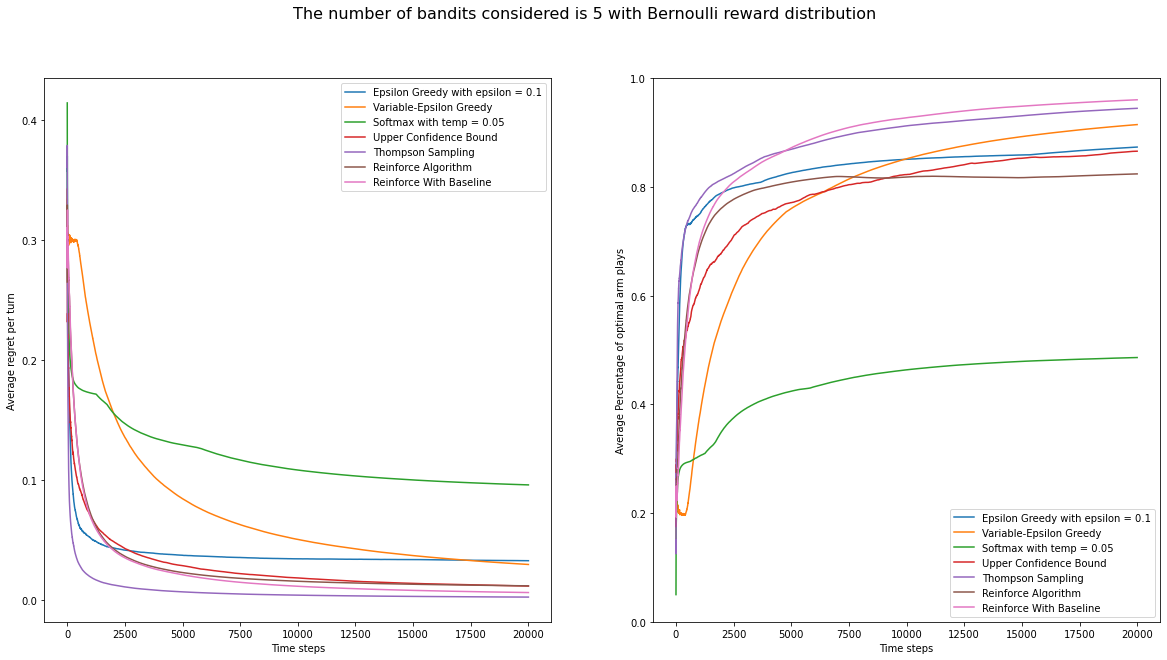



******************************** NUMBER OF ARMS : 10 ********************************

Each algorithm was played 20 times and the episode length was 20000

The total regret accumulated over time for Epsilon Greedy with epsilon = 0.1 is 888.183

The total regret accumulated over time for Variable-Epsilon Greedy is 1428.130

The total regret accumulated over time for Softmax with temp = 0.05 is 2655.675

The total regret accumulated over time for Upper Confidence Bound is 445.021

The total regret accumulated over time for Thompson Sampling is 49.621

The total regret accumulated over time for Reinforce Algorithm is 413.656

The total regret accumulated over time for Reinforce With Baseline is 317.805



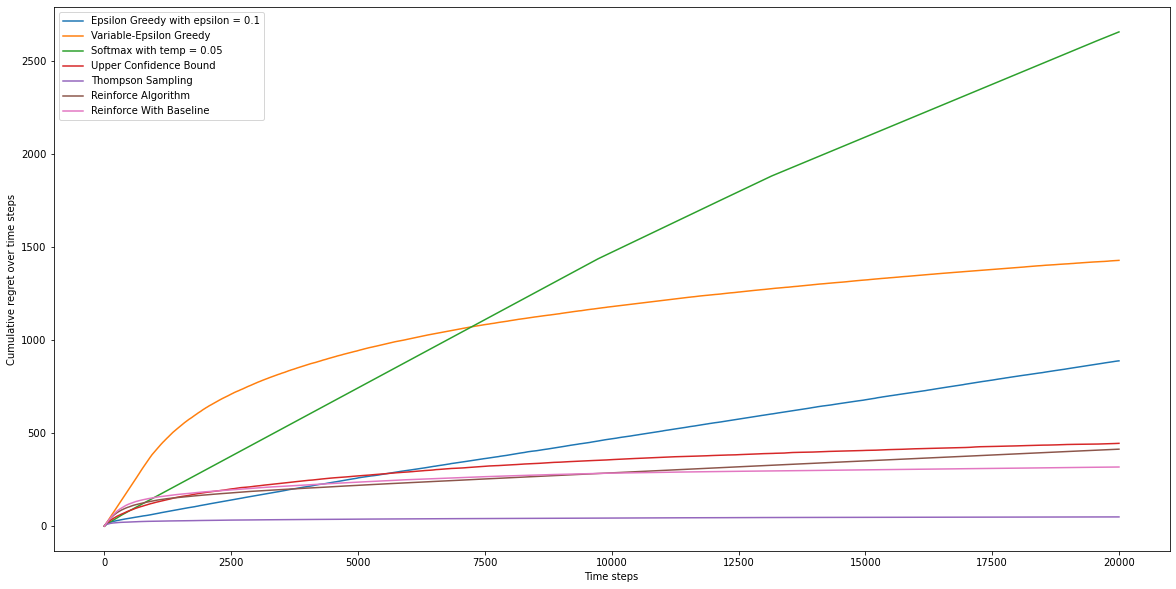

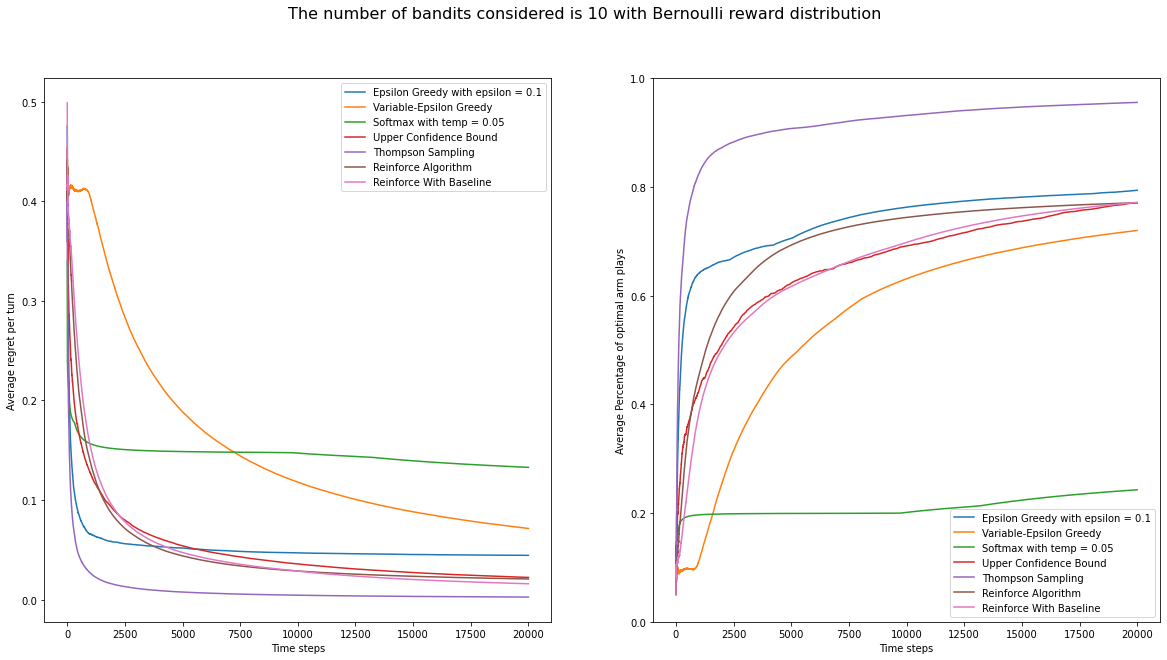

In [15]:
for K in K_list:
    
  
  mab_list = [] #list of instantiation of MAB 
  for _ in range(num_runs):
        bandits_mean = np.random.uniform(low = 0, high = 1, size = K) 
        opt_arm      = np.argmax(bandits_mean)
        
        mab = MAB('Bernoulli', bandits_mean) 
        mab_list.append(mab)


  fig1, ax1 = plt.subplots(1,1, figsize=(20, 10))
  fig2, axs = plt.subplots(1,2, figsize=(20, 10))
  print("====================================================================================================================================================================================")
  print("====================================================================================================================================================================================\n")
  print(f"\n******************************** NUMBER OF ARMS : {K} ********************************\n")
  print(f"Each algorithm was played {num_runs} times and the episode length was {T}\n")
  
  for algo_number in range(num_algorithms):
      
      cummulative_avg_regret  = np.zeros((1, T+1))  
      
      avg_regret_per_turn     = np.zeros((1,T)) 

      avg_percent_optimal_arm = np.zeros((1,T+1))

      running_avg_regret_per_turn = np.zeros((1,T+1))

      for run in range(num_runs): 
            
          mab = mab_list[run]
          opt_arm = np.argmax(mab.bandits_mean)
       
          algorithms = [Epsilon_Greedy(epsilon), Variable_Epsilon_Greedy(1), Softmax(temp = softmax_temp), UCB(), TS('Bernoulli'), Reinforce(K), Reinforce_Baseline(K)]

 
          algorithm  = algorithms[algo_number]  
      
          no_arms_pulled  = np.zeros((1,K))

          reward_estimate = np.zeros((1,K)) 
          
          rewards_obtained = np.zeros((1, T)) 
          
      
          regrets_achieved   = np.zeros((1,T)) 

          cummulative_regret = np.zeros((1,T+1)) 

          avg_regret_over_T  = np.zeros((1,T+1)) 

          percent_optimal_arm = np.zeros((1,T+1)) 
          
          avg_reward = np.zeros((1,T+1))

          for t in range(T): 
              
              a_t  = algorithm.action(reward_estimate, no_arms_pulled, K)
              no_arms_pulled[0,a_t] += 1

              percent_optimal_arm[0,t+1] = percent_optimal_arm[0,t] + ((a_t == opt_arm) - percent_optimal_arm[0,t])/(t+1)

              reward, regret          = mab.pull_arm(a_t)
              reward_estimate[0,a_t] += ((reward - reward_estimate[0,a_t])/no_arms_pulled[0,a_t]) 
              
              avg_reward = np.sum(reward_estimate * no_arms_pulled)/(t+1)

              if (algo_labels[algo_number] == "Reinforce Algorithm" or algo_labels[algo_number] == "Reinforce With Baseline"):
                algorithm.update_weights(a_t, reward, avg_reward)
              
              rewards_obtained[0,t] = reward
              
              regrets_achieved[0,t] = regret

              cummulative_regret[0,t+1] = regret + cummulative_regret[0,t]

              avg_regret_over_T[0,t+1] = avg_regret_over_T[0,t] + ((regret- avg_regret_over_T[0,t])/(t+1)) 

          cummulative_avg_regret = cummulative_avg_regret + ((cummulative_regret - cummulative_avg_regret)/(run+1))   
          avg_regret_per_turn = avg_regret_per_turn + ((regrets_achieved - avg_regret_per_turn)/(run+1))
      
          running_avg_regret_per_turn += (avg_regret_over_T - running_avg_regret_per_turn)/(run+1)
          avg_percent_optimal_arm += (percent_optimal_arm - avg_percent_optimal_arm)/(run+1)
          
      ax1.plot(cummulative_avg_regret[0,1:], label = f'{algo_labels[algo_number]}')  
      axs[0].plot(running_avg_regret_per_turn[0,1:], label = f'{algo_labels[algo_number]}')
      axs[1].plot(avg_percent_optimal_arm[0,1:], label = f'{algo_labels[algo_number]}')

      print(f"The total regret accumulated over time for {algo_labels[algo_number]} is {cummulative_avg_regret[0,-1]:.3f}\n")

  ax1.legend()
  axs[0].legend()
  axs[1].legend()
  ax1.set(xlabel = "Time steps", ylabel = "Cumulative regret over time steps")
  axs[0].set(xlabel = "Time steps", ylabel = "Average regret per turn")
  axs[1].set(xlabel = "Time steps", ylabel = "Average Percentage of optimal arm plays", ylim = [0,1])
  plt.suptitle(f"The number of bandits considered is {K} with Bernoulli reward distribution", fontsize = '16')
  plt.show()

In [16]:
K_list            = [2, 5, 10]
stdv_list         = [0.5, 1]


T = 30000  
num_runs = 50    
num_algorithms = 7

epsilon      = 0.1

softmax_temp = 0.05

algo_labels = [f"Epsilon Greedy with epsilon = {epsilon}", "Variable-Epsilon Greedy", f"Softmax with temp = {softmax_temp}", "Upper Confidence Bound", "Thompson Sampling", "Reinforce Algorithm", "Reinforce With Baseline"]    




******************************** Standard Deviation of each arm : 0.5 ********************************


******************************** NUMBER OF ARMS : 2 ********************************

Each algorithm was played 50 times and the episode length was 30000

The total regret accumulated over time for Epsilon Greedy with epsilon = 0.1 is 540.850

The total regret accumulated over time for Variable-Epsilon Greedy is 179.614

The total regret accumulated over time for Softmax with temp = 0.05 is 878.353

The total regret accumulated over time for Upper Confidence Bound is 67.993

The total regret accumulated over time for Thompson Sampling is 280.121

The total regret accumulated over time for Reinforce Algorithm is 56.398

The total regret accumulated over time for Reinforce With Baseline is 49.287



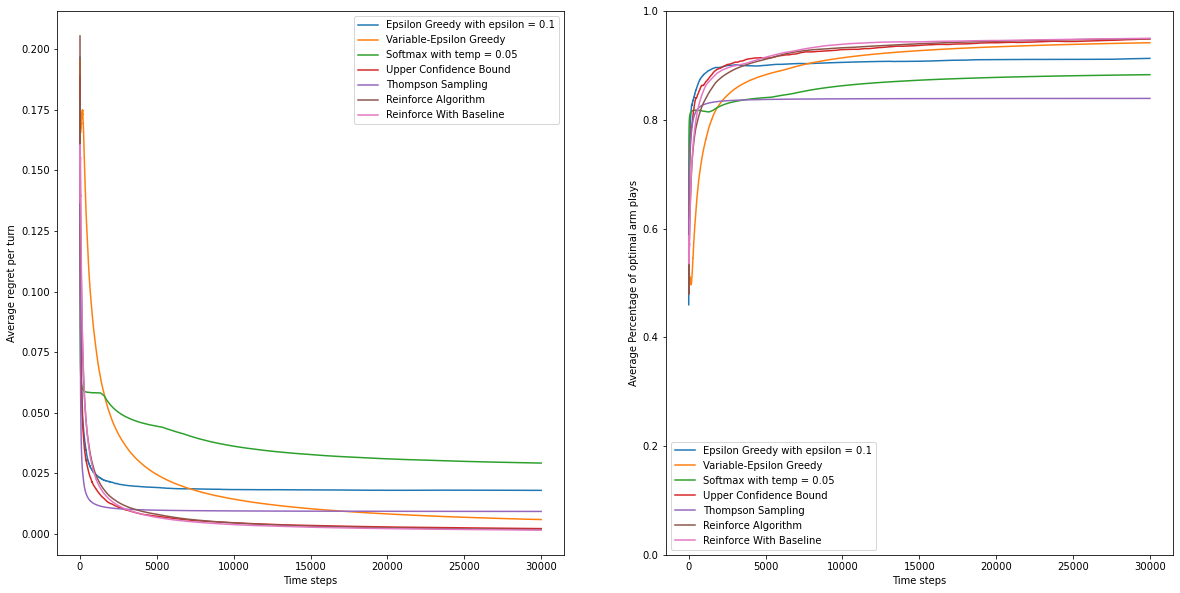

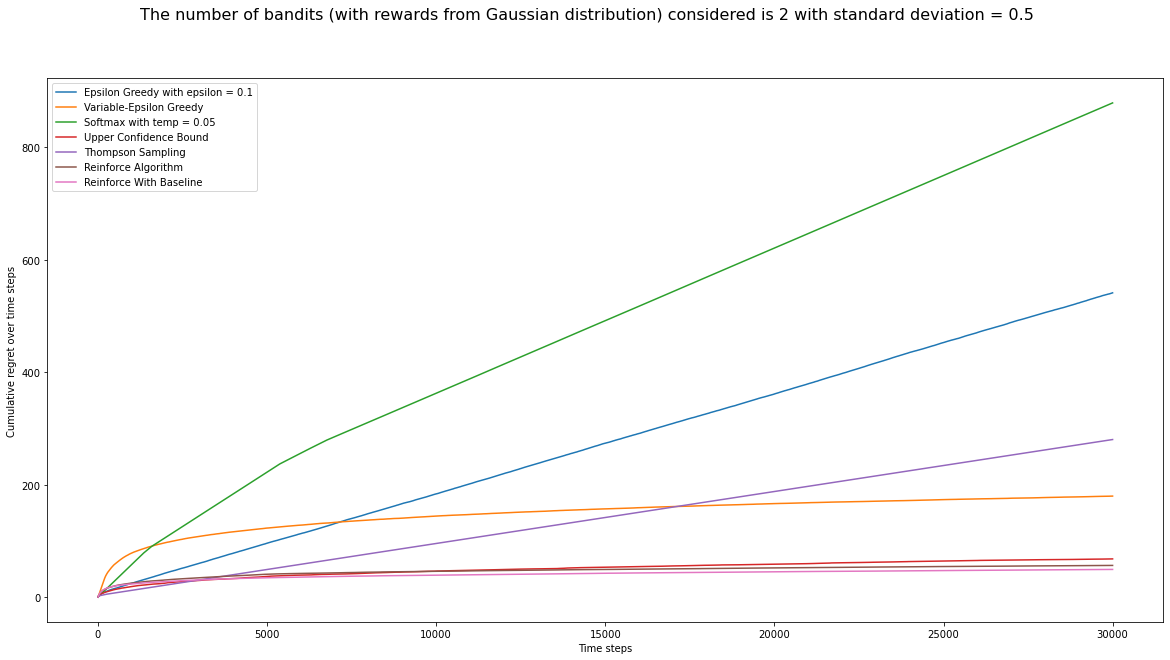



******************************** Standard Deviation of each arm : 0.5 ********************************


******************************** NUMBER OF ARMS : 5 ********************************

Each algorithm was played 50 times and the episode length was 30000

The total regret accumulated over time for Epsilon Greedy with epsilon = 0.1 is 1050.648

The total regret accumulated over time for Variable-Epsilon Greedy is 724.060

The total regret accumulated over time for Softmax with temp = 0.05 is 2571.061

The total regret accumulated over time for Upper Confidence Bound is 251.948

The total regret accumulated over time for Thompson Sampling is 597.223

The total regret accumulated over time for Reinforce Algorithm is 256.118

The total regret accumulated over time for Reinforce With Baseline is 111.079



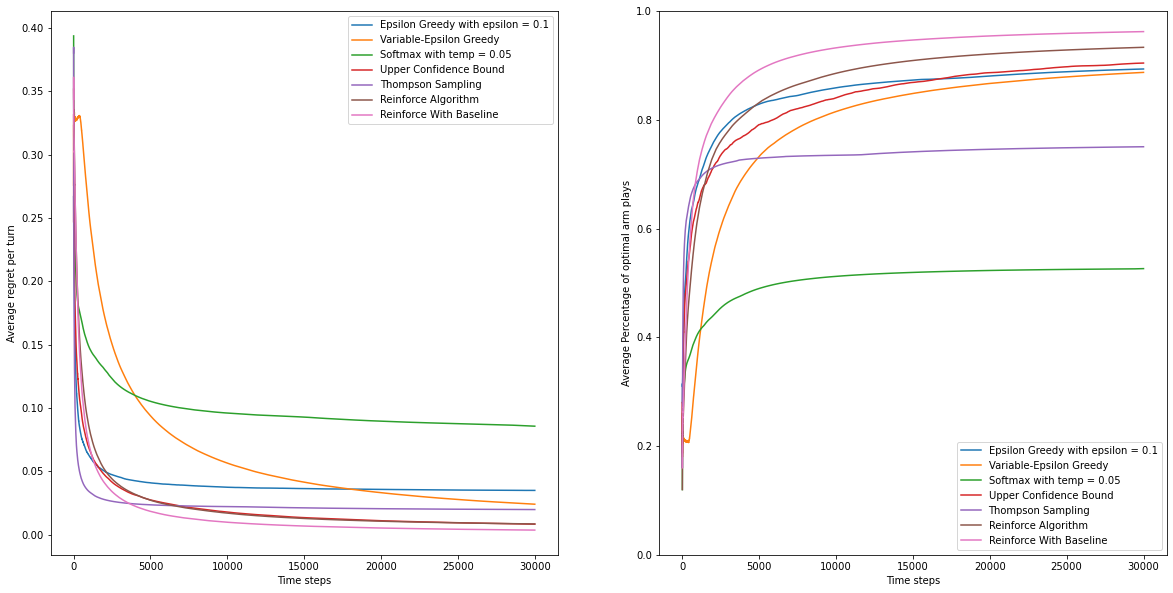

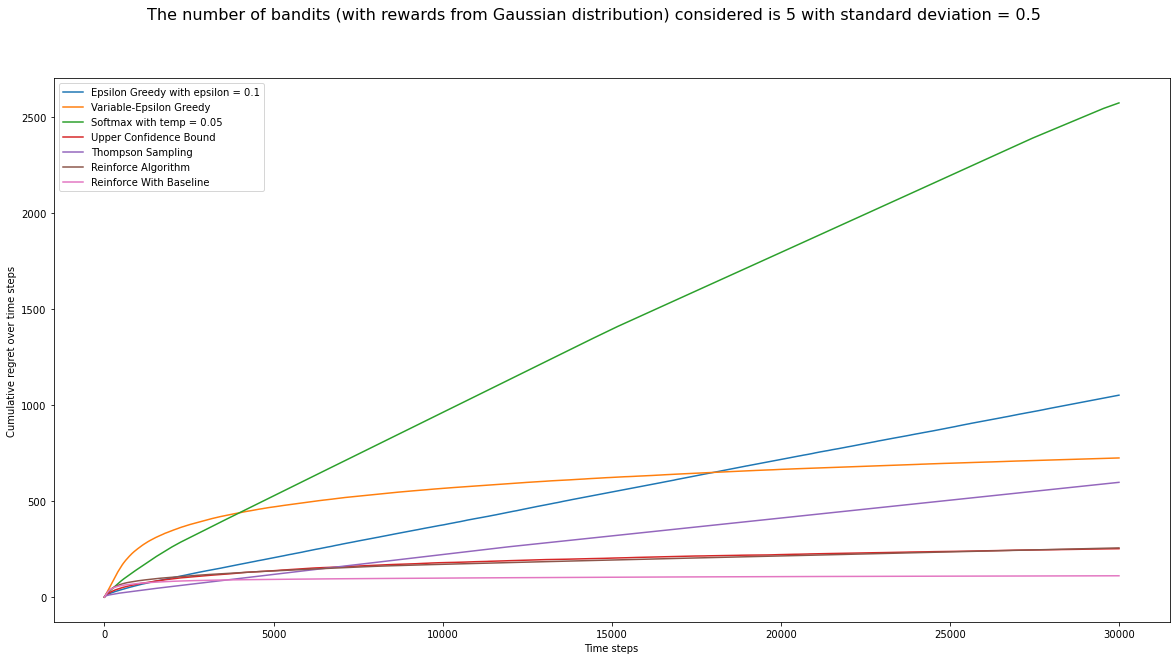



******************************** Standard Deviation of each arm : 0.5 ********************************


******************************** NUMBER OF ARMS : 10 ********************************

Each algorithm was played 50 times and the episode length was 30000

The total regret accumulated over time for Epsilon Greedy with epsilon = 0.1 is 1329.441

The total regret accumulated over time for Variable-Epsilon Greedy is 1540.841

The total regret accumulated over time for Softmax with temp = 0.05 is 3275.977

The total regret accumulated over time for Upper Confidence Bound is 492.695

The total regret accumulated over time for Thompson Sampling is 993.254

The total regret accumulated over time for Reinforce Algorithm is 532.650

The total regret accumulated over time for Reinforce With Baseline is 365.753



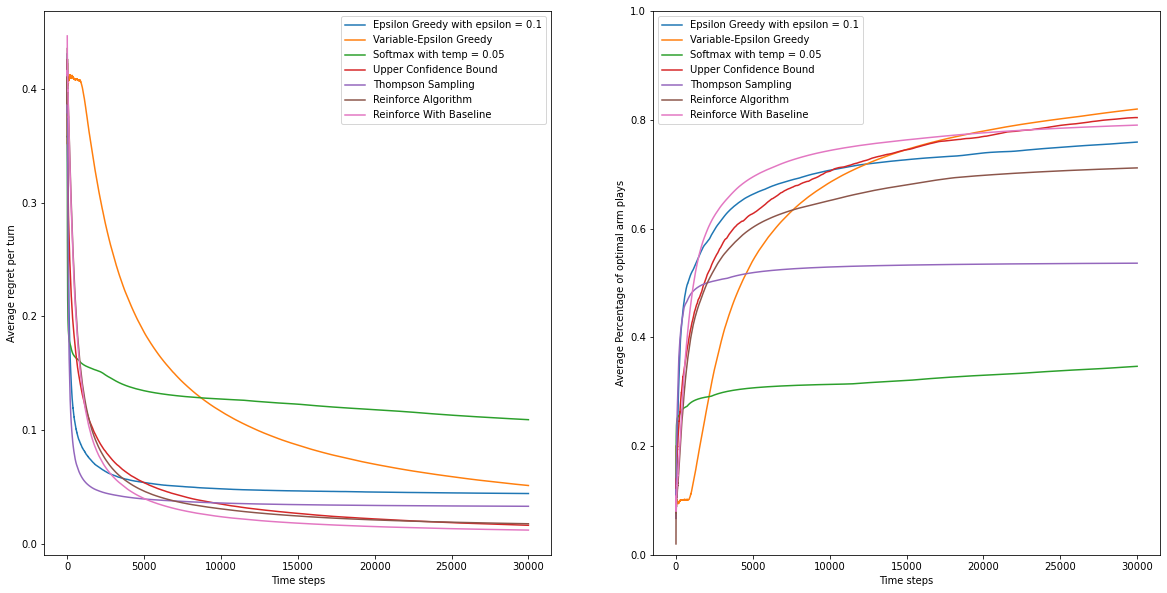

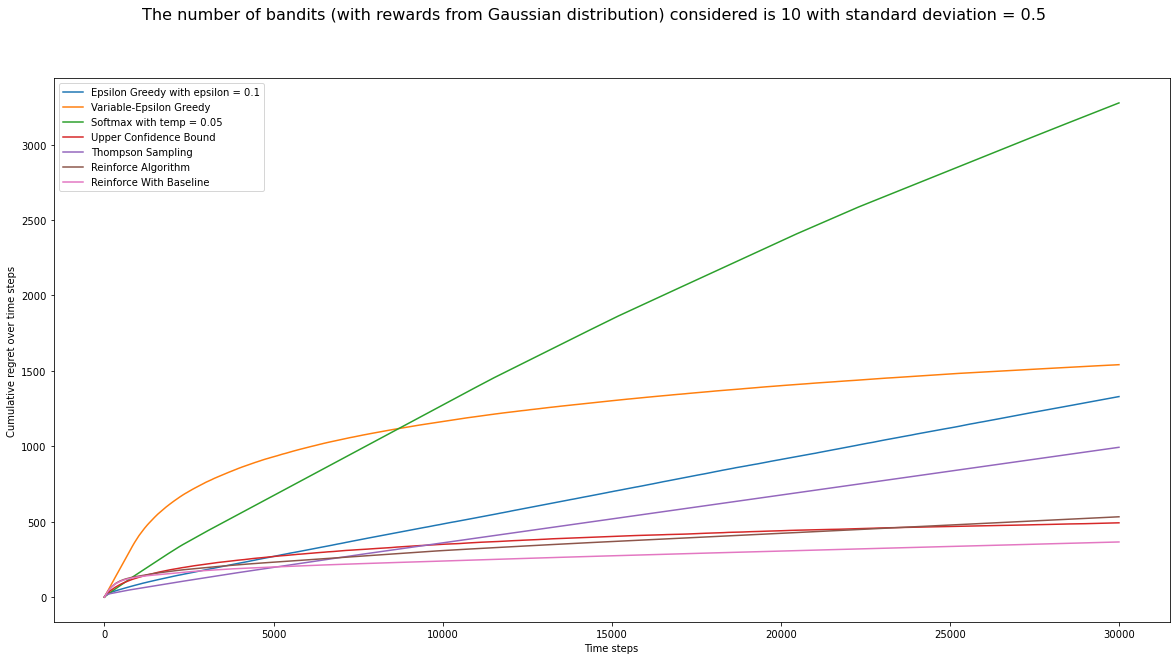



******************************** Standard Deviation of each arm : 1 ********************************


******************************** NUMBER OF ARMS : 2 ********************************

Each algorithm was played 50 times and the episode length was 30000

The total regret accumulated over time for Epsilon Greedy with epsilon = 0.1 is 559.431

The total regret accumulated over time for Variable-Epsilon Greedy is 228.104

The total regret accumulated over time for Softmax with temp = 0.05 is 1479.329

The total regret accumulated over time for Upper Confidence Bound is 84.947

The total regret accumulated over time for Thompson Sampling is 434.207

The total regret accumulated over time for Reinforce Algorithm is 88.802

The total regret accumulated over time for Reinforce With Baseline is 57.559



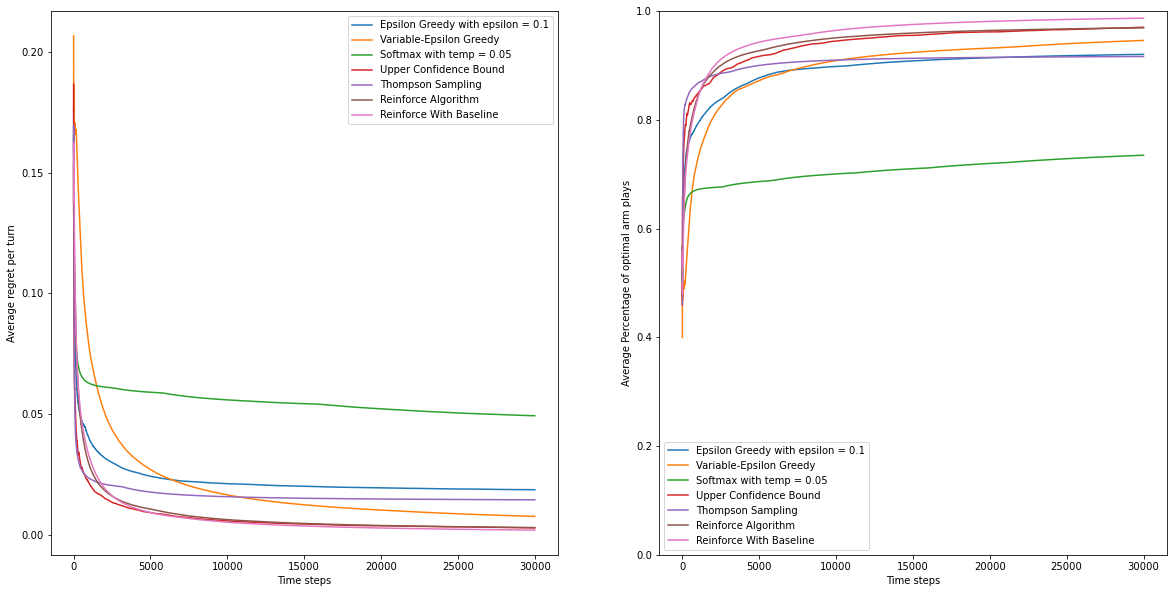

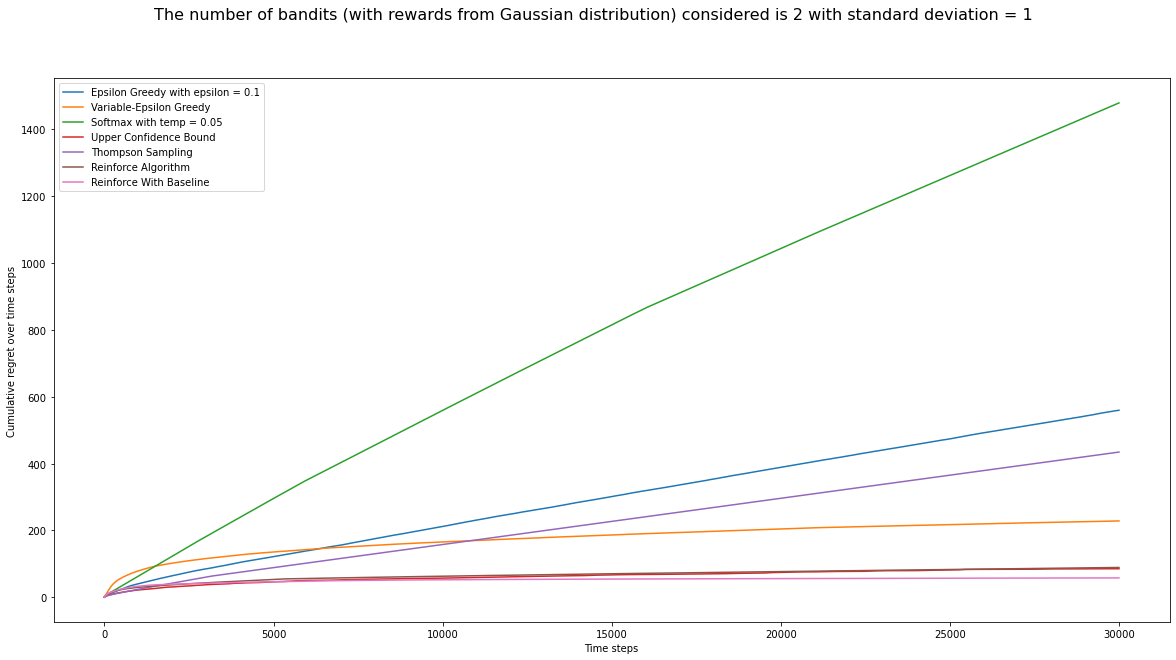



******************************** Standard Deviation of each arm : 1 ********************************


******************************** NUMBER OF ARMS : 5 ********************************

Each algorithm was played 50 times and the episode length was 30000

The total regret accumulated over time for Epsilon Greedy with epsilon = 0.1 is 1134.023

The total regret accumulated over time for Variable-Epsilon Greedy is 714.697

The total regret accumulated over time for Softmax with temp = 0.05 is 2740.464

The total regret accumulated over time for Upper Confidence Bound is 246.299

The total regret accumulated over time for Thompson Sampling is 732.198

The total regret accumulated over time for Reinforce Algorithm is 358.873

The total regret accumulated over time for Reinforce With Baseline is 381.992



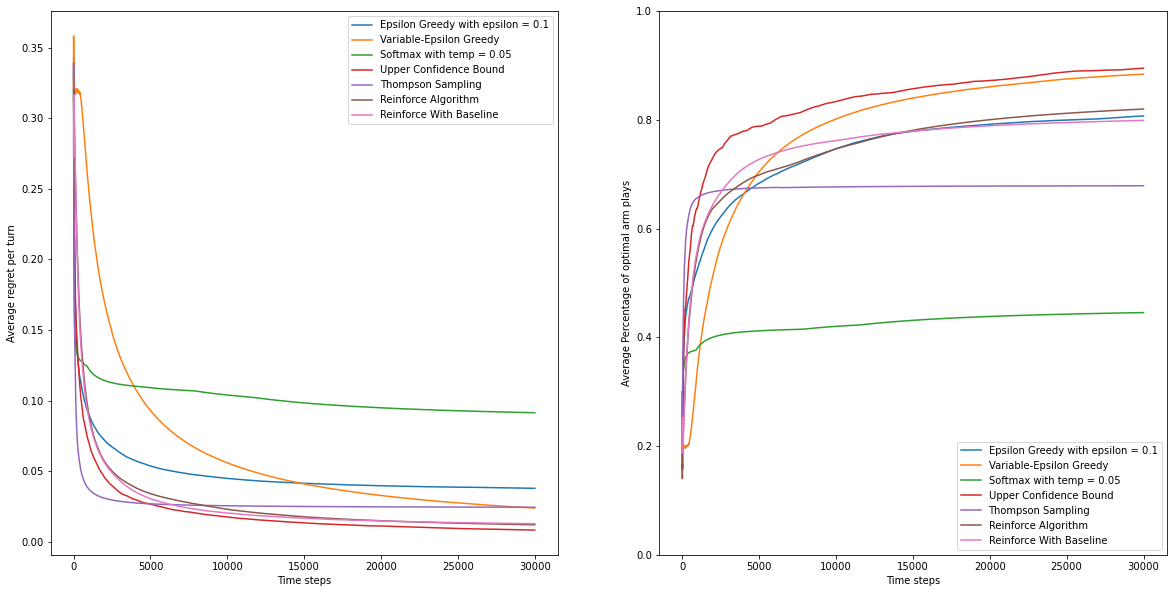

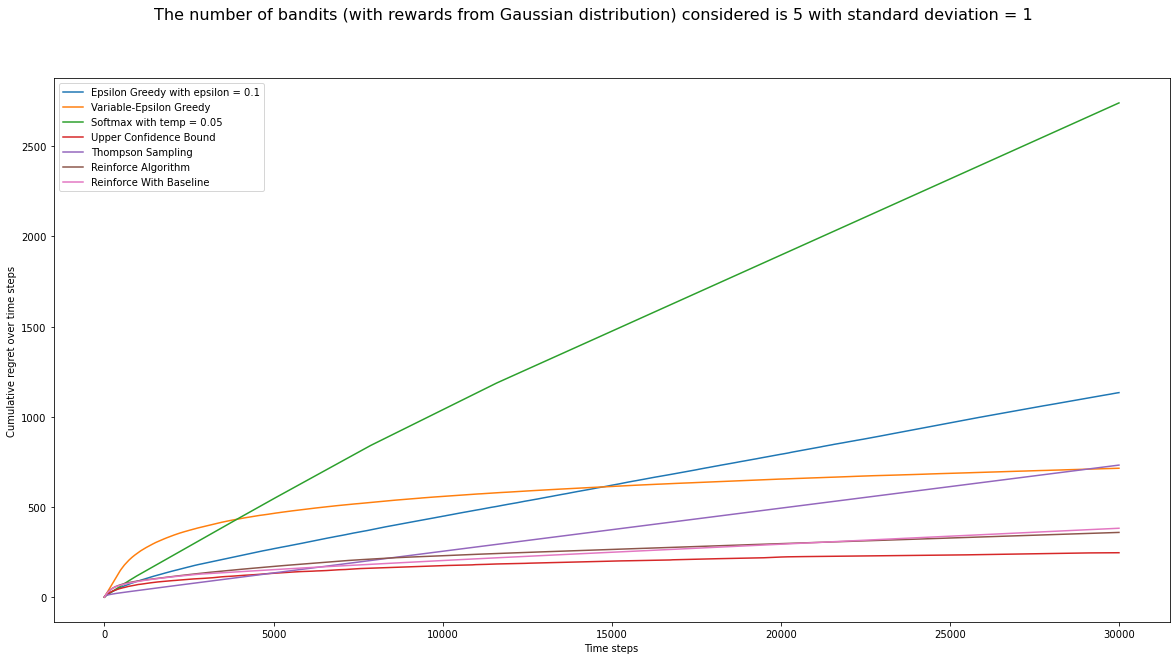



******************************** Standard Deviation of each arm : 1 ********************************


******************************** NUMBER OF ARMS : 10 ********************************

Each algorithm was played 50 times and the episode length was 30000

The total regret accumulated over time for Epsilon Greedy with epsilon = 0.1 is 1561.040

The total regret accumulated over time for Variable-Epsilon Greedy is 1628.637

The total regret accumulated over time for Softmax with temp = 0.05 is 2924.793

The total regret accumulated over time for Upper Confidence Bound is 503.487

The total regret accumulated over time for Thompson Sampling is 847.672

The total regret accumulated over time for Reinforce Algorithm is 785.860

The total regret accumulated over time for Reinforce With Baseline is 589.659



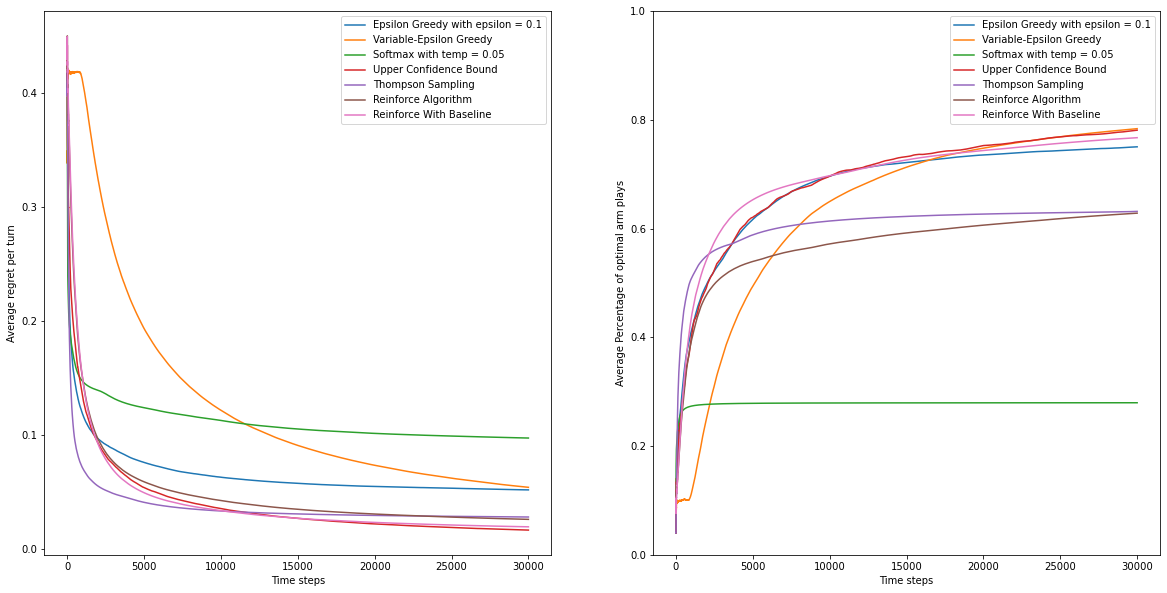

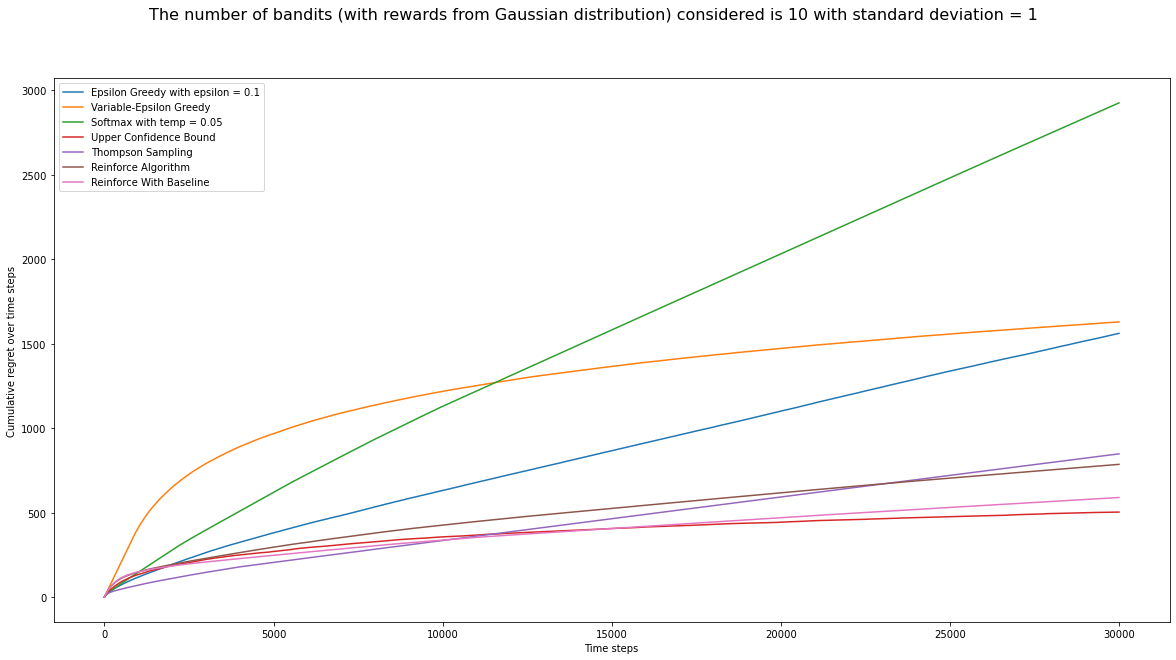

In [17]:
for stdv in stdv_list:
  for K in K_list:


    mab_list = [] 
    for _ in range(num_runs):
        bandits_mean = np.random.uniform(low = 0, high = 1, size = K) 
       
        mab = MAB('Gaussian', bandits_mean,stdv) 
        mab_list.append(mab)

    
    fig2, axs = plt.subplots(1,2, figsize=(20, 10))
    fig1, ax1 = plt.subplots(1,1, figsize = (20,10))
    print("====================================================================================================================================================================================")
    print("====================================================================================================================================================================================\n")
    print(f"\n******************************** Standard Deviation of each arm : {stdv} ********************************\n")
    print(f"\n******************************** NUMBER OF ARMS : {K} ********************************\n")
    print(f"Each algorithm was played {num_runs} times and the episode length was {T}\n")
    

    for algo_number in range(num_algorithms):
        
        cummulative_avg_regret  = np.zeros((1, T+1))  
     
        avg_regret_per_turn     = np.zeros((1,T)) 

        avg_percent_optimal_arm = np.zeros((1,T+1))

        running_avg_regret_per_turn = np.zeros((1,T+1))

        for run in range(num_runs):
            
            mab = mab_list[run]
            opt_arm = np.argmax(mab.bandits_mean)

            algorithms = [Epsilon_Greedy(epsilon), Variable_Epsilon_Greedy(1), Softmax(temp = softmax_temp), UCB(), TS_Gaussian(K), Reinforce(K), Reinforce_Baseline(K)]
    
            
            
            algorithm  = algorithms[algo_number]  
        
            no_arms_pulled  = np.zeros((1,K))

            reward_estimate = np.zeros((1,K)) 
            
            rewards_obtained = np.zeros((1, T)) 
     
            regrets_achieved   = np.zeros((1,T)) 

            
            cummulative_regret = np.zeros((1,T+1)) 

            avg_regret_over_T  = np.zeros((1,T+1)) 

            percent_optimal_arm = np.zeros((1,T+1)) 
            
            avg_reward = np.zeros((1,T+1))

            for t in range(T): 
                

                a_t  = algorithm.action(reward_estimate, no_arms_pulled, K)
                no_arms_pulled[0,a_t] += 1

                percent_optimal_arm[0,t+1] = percent_optimal_arm[0,t] + ((a_t == opt_arm) - percent_optimal_arm[0,t])/(t+1)

                reward, regret          = mab.pull_arm(a_t)
                reward_estimate[0,a_t] += ((reward - reward_estimate[0,a_t])/no_arms_pulled[0,a_t]) 
                
                avg_reward = np.sum(reward_estimate * no_arms_pulled)/(t+1)

                if (algo_labels[algo_number] == "Thompson Sampling" ):
                  algorithm.update(reward_estimate[0,a_t], reward, a_t, no_arms_pulled[0,a_t])


                if (algo_labels[algo_number] == "Reinforce Algorithm" or algo_labels[algo_number] == "Reinforce With Baseline"):
                  algorithm.update_weights(a_t, reward, avg_reward)
                
                rewards_obtained[0,t] = reward
                
                regrets_achieved[0,t] = regret

                cummulative_regret[0,t+1] = regret + cummulative_regret[0,t]

                avg_regret_over_T[0,t+1] = avg_regret_over_T[0,t] + ((regret- avg_regret_over_T[0,t])/(t+1)) 

            cummulative_avg_regret = cummulative_avg_regret + ((cummulative_regret - cummulative_avg_regret)/(run+1))   
            avg_regret_per_turn = avg_regret_per_turn + ((regrets_achieved - avg_regret_per_turn)/(run+1))
        
            running_avg_regret_per_turn += (avg_regret_over_T - running_avg_regret_per_turn)/(run+1)
            avg_percent_optimal_arm += (percent_optimal_arm - avg_percent_optimal_arm)/(run+1)

        print(f"The total regret accumulated over time for {algo_labels[algo_number]} is {cummulative_avg_regret[0,-1]:.3f}\n")
        ax1.plot(cummulative_avg_regret[0,1:], label = f'{algo_labels[algo_number]}')  
        axs[0].plot(running_avg_regret_per_turn[0,1:], label = f'{algo_labels[algo_number]}')
        axs[1].plot(avg_percent_optimal_arm[0,1:], label = f'{algo_labels[algo_number]}')

    ax1.legend()
    axs[0].legend()
    axs[1].legend()
    ax1.set(xlabel = "Time steps", ylabel = "Cumulative regret over time steps")
    axs[0].set(xlabel = "Time steps", ylabel = "Average regret per turn")
    axs[1].set(xlabel = "Time steps", ylabel = "Average Percentage of optimal arm plays", ylim = [0,1])
    plt.suptitle(f"The number of bandits (with rewards from Gaussian distribution) considered is {K} with standard deviation = {stdv}", fontsize = '16')
    plt.show()